In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import arviz as az
from scipy import stats

from src.utils import basic as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## What proportion of earth's surface is covered with water?

### Workflow
1. Define Generative Mode
2. Define Estimand: proportion of globe covered in water
3. Design a statistical means to produce estimate
4. Test (3) using (2)
5. Analyze real data

## 1, 2. Define Generative Model

This model defines how p, N affect the values of W and L.  
W,L -> f(p,N)

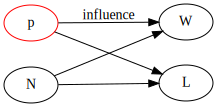

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("p", "L"),
        ("N", "W"),
        ("N", "L"),
    ],
    graph_direction="LR",
    node_props={
        "p": {"color": "red"}
    },
    edge_props={
        ("p", "W"): {"label": "influence"},
    }
)

## 3. Design a statistical way tp produce estimate

In [263]:

def calculate_n_ways_possible(observations: str, n_water: int, resolution: int):
    """ 
    Calculate the number of ways to observing water ('W') given the toss of a globe with `resolution` number of sides and `n_water` faces.
    """
    assert n_water <= resolution # "n_water must be less than or equal to resolution"
    
    # convert the observations string to an array
    observations = np.array(list(observations.upper()))

    # create n-sided globe with n_water water faces
    globe = np.array(["W"]*n_water + ["L"]*(resolution-n_water))
    
    p_water = n_water / resolution
    # Tally up ways to obtain each observation given the possible outcomes
    # Boundary conditions
    if "W" in observations and n_water == 0:
        n_ways = 0
    elif "L" in observations and n_water == resolution:
        n_ways = 0
    else:
        log_n_ways = 0
        for obs in observations:
            possibility = np.sum(obs == globe)
            log_n_ways += np.log(possibility)
        n_ways = np.round(np.exp(log_n_ways, dtype=np.float64)).astype(np.int64)
    
    return n_ways, p_water   

def run_globe_tossing_simulation(observations, resolution, calculate_n_possible_ways=None):
    """
    Simulate globe tossing using Monte Carlo sampling.
    """
    # for bayesian updating
    current_n_possible_ways = calculate_n_possible_ways if calculate_n_possible_ways is not None else np.array([])
    
    print(f"Observations: '{observations}'")
    p_water = np.array([])
    for n_water in range(0, resolution + 1):
        n_land = resolution - n_water
        n_possible_ways, p_water_ = calculate_n_ways_possible(observations, n_water, resolution)
        p_water = np.append(p_water, p_water_)
        
        globe_sides = "W"*n_water + "L"*n_land
        print(f"({n_water}) {globe_sides} \t\t p(W) = {p_water_:.2f} \t\t {n_possible_ways} Ways to Produce")
        
        current_n_possible_ways = np.append(current_n_possible_ways, n_possible_ways)
        
    return current_n_possible_ways, p_water


RESOLUTION = 4
observations = "WLW"

n_possible_ways, p_water = run_globe_tossing_simulation(observations, RESOLUTION)
    

Observations: 'WLW'
(0) LLLL 		 p(W) = 0.00 		 0 Ways to Produce
(1) WLLL 		 p(W) = 0.25 		 3 Ways to Produce
(2) WWLL 		 p(W) = 0.50 		 8 Ways to Produce
(3) WWWL 		 p(W) = 0.75 		 9 Ways to Produce
(4) WWWW 		 p(W) = 1.00 		 0 Ways to Produce


### Bayesian updating under new observation

In [216]:
new_observation_possible_ways, _ = run_globe_tossing_simulation("W", RESOLUTION)

# bayesian updating
n_possible_ways *= new_observation_possible_ways

print("\n Updated Probabilities given new observation:")
for idx in range(0, RESOLUTION + 1):
    print(f"({idx+1}) \tp(W) = {p_water[idx]:1.2}\t\t{int(n_possible_ways[idx])} Ways to Produce")

Observations: 'W'
(0) LLLL 		 p(W) = 0.00 		 0 Ways to Produce
(1) WLLL 		 p(W) = 0.25 		 1 Ways to Produce
(2) WWLL 		 p(W) = 0.50 		 2 Ways to Produce
(3) WWWL 		 p(W) = 0.75 		 3 Ways to Produce
(4) WWWW 		 p(W) = 1.00 		 4 Ways to Produce

 Updated Probabilities given new observation:
(1) 	p(W) = 0.0		0 Ways to Produce
(2) 	p(W) = 0.25		3 Ways to Produce
(3) 	p(W) = 0.5		16 Ways to Produce
(4) 	p(W) = 0.75		27 Ways to Produce
(5) 	p(W) = 1.0		0 Ways to Produce


#### Taking whole sample

In [269]:
RESOLUTION = 4
observations = "LLWWWLWWW"
n_W = np.sum(np.array(list(observations)) == "W")
n_L = np.sum(np.array(list(observations)) == "L")
n_possible_ways, p_water = run_globe_tossing_simulation(observations, RESOLUTION)

Observations: 'LLWWWLWWW'
(0) LLLL 		 p(W) = 0.00 		 0 Ways to Produce
(1) WLLL 		 p(W) = 0.25 		 27 Ways to Produce
(2) WWLL 		 p(W) = 0.50 		 512 Ways to Produce
(3) WWWL 		 p(W) = 0.75 		 729 Ways to Produce
(4) WWWW 		 p(W) = 1.00 		 0 Ways to Produce


Both, Bayesian updating and taking whole sample together, produces same result

### Solving with analytical solution $W, L = (p)^{W} * (1-p)^{L}$

In [272]:
def calculate_analytic_n_ways_possible(p, n_W, n_L, resolution=RESOLUTION):
    """This scales much better than the brute-force method"""
    return (resolution * p) ** n_W * (resolution - resolution * p) ** n_L

analytic_n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L) for p in p_water])
assert (analytic_n_possible_ways == n_possible_ways).all()

Proportion	Ways	Probability
0.0			0			0.00
0.25			94143178827			0.08
0.5			1099511627776			0.92
0.75			129140163			0.00
1.0			0			0.00


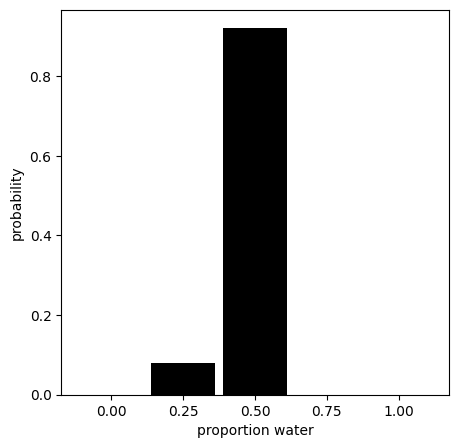

In [249]:
n_possible_probabilities = n_possible_ways / np.sum(n_possible_ways)

print("Proportion\tWays\tProbability")
for p, n_w, n_p in zip(p_water, n_possible_ways, n_possible_probabilities):
    print(f"{p:1.12}\t\t\t{n_w:0.0f}\t\t\t{n_p:1.2f}")
    
probs = np.linspace(0, 1, RESOLUTION+1)
plt.subplots(figsize=(5, 5))
plt.bar(x=probs, height=n_possible_probabilities, width= .9 / RESOLUTION, color='k')
plt.xticks(probs);
plt.ylabel("probability")
plt.xlabel("proportion water");

## 4. Test (3) using (1)

1. Code generative simulation
2. Code an estimator
3. Test 2 with 1

### 4.1 Generative Simulation

In [204]:
from pprint import pprint
np.random.seed(1)

def simulate_globe_toss(p=0.7, N=9):
    """
    Simulate globe tossing.
    p: probability of water
    N: number of globe tosses
    """
    return np.random.choice(list("WL"), size=N, p=[p, 1-p])

print(simulate_globe_toss())

# Testing extreme values 
pprint([simulate_globe_toss(p=1, N=11).tolist() for _ in range(10)])

['W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
[['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']]


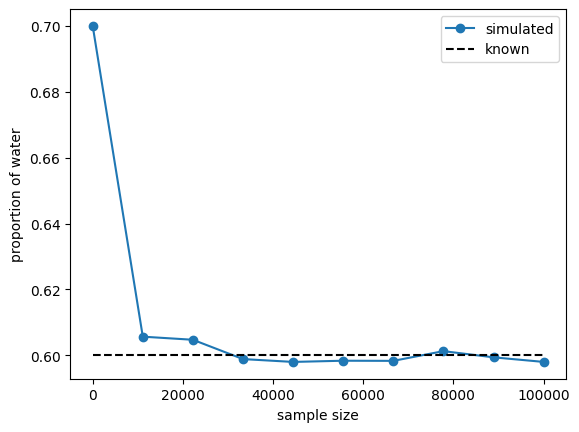

In [254]:
# # Setting the seed for reproducibility
# np.random.seed(42)

# Large sample should converge to the true probability
known_p = 0.6

simulated_ps = []
sample_sizes = np.linspace(10, 100_000, 10, dtype=int)

for N in sample_sizes:
    simulated_p = np.sum(simulate_globe_toss(p=known_p, N=N) == "W") / N
    simulated_ps.append(simulated_p)

plt.plot(sample_sizes, simulated_ps, 'o-', label='simulated')
plt.plot(sample_sizes, [known_p]*len(sample_sizes), 'k--', label='known')
plt.xlabel("sample size")
plt.ylabel("proportion of water")
plt.legend();
plt.show()
    

### 4.2 Code the estimator

##### Creating new function to calculate probability rather than n_ways to avoid memory overflow

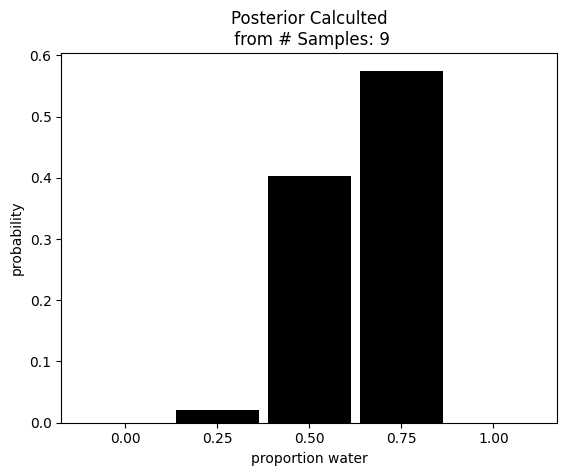

In [278]:
def compute_posterior(observations, resolution=RESOLUTION, ax=None):
    n_W = np.sum(np.array(list(observations)) == "W")
    n_L = np.sum(np.array(list(observations)) == "L")
    
    p_water = np.linspace(0, 1, resolution+1)
    n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L, resolution) for p in p_water])

    posterior = n_possible_ways / np.sum(n_possible_ways)
    
    probs = np.linspace(0, 1, resolution+1)
    return posterior, probs

def plot_posterior(observations, resolution=RESOLUTION, ax=None):
    posterior, probs = compute_posterior(observations, resolution=resolution, ax=ax)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=probs, height=posterior, width= .9 / resolution, color='k')
    plt.xticks(probs)
    plt.ylabel("probability")
    plt.xlabel("proportion water");
    plt.title(f"Posterior Calculted\n from # Samples: {len(observations)}")



plot_posterior(observations, ax=plt.gca())
    
    

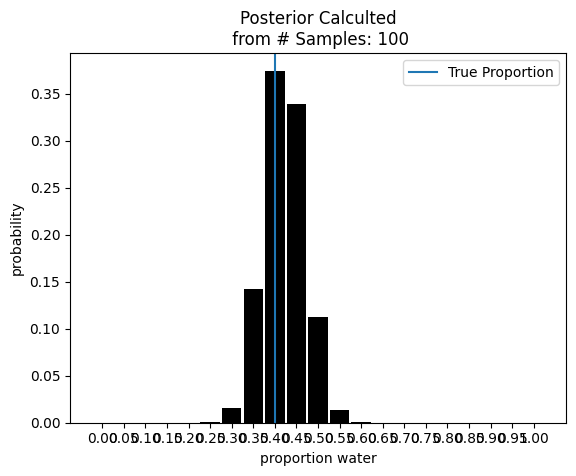

In [279]:
np.random.seed(2)
p = .4
simulated_observations = "".join(simulate_globe_toss(p=p, N=100))
plot_posterior(simulated_observations, resolution=20)
plt.axvline(p, color='C0', label='True Proportion')
plt.legend();

## Infinite Possibilities

Moving from an N-sided globe to an infinity-sided globe


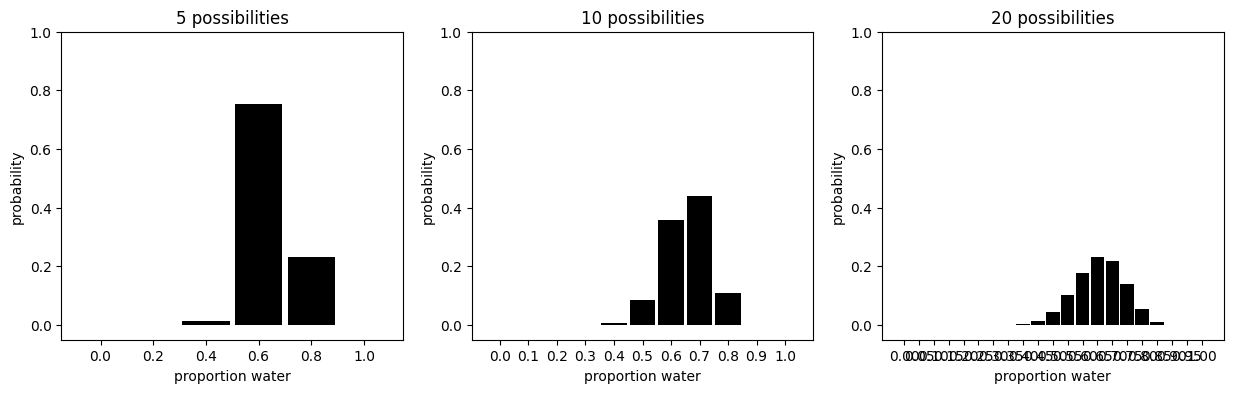

In [280]:
np.random.seed(12)
p = .7
simulated_observations = "".join(simulate_globe_toss(p=p, N=30))
_, axs = plt.subplots(1, 3, figsize=(15, 4))
for ii, possibilities in enumerate([5, 10, 20]):
    plot_posterior(simulated_observations, resolution=possibilities, ax=axs[ii])
    plt.ylim([-.05, 1])
    axs[ii].set_title(f"{possibilities} possibilities")

Beta Distributions

Analytical function to get pdf as number of possibilities -> infinity

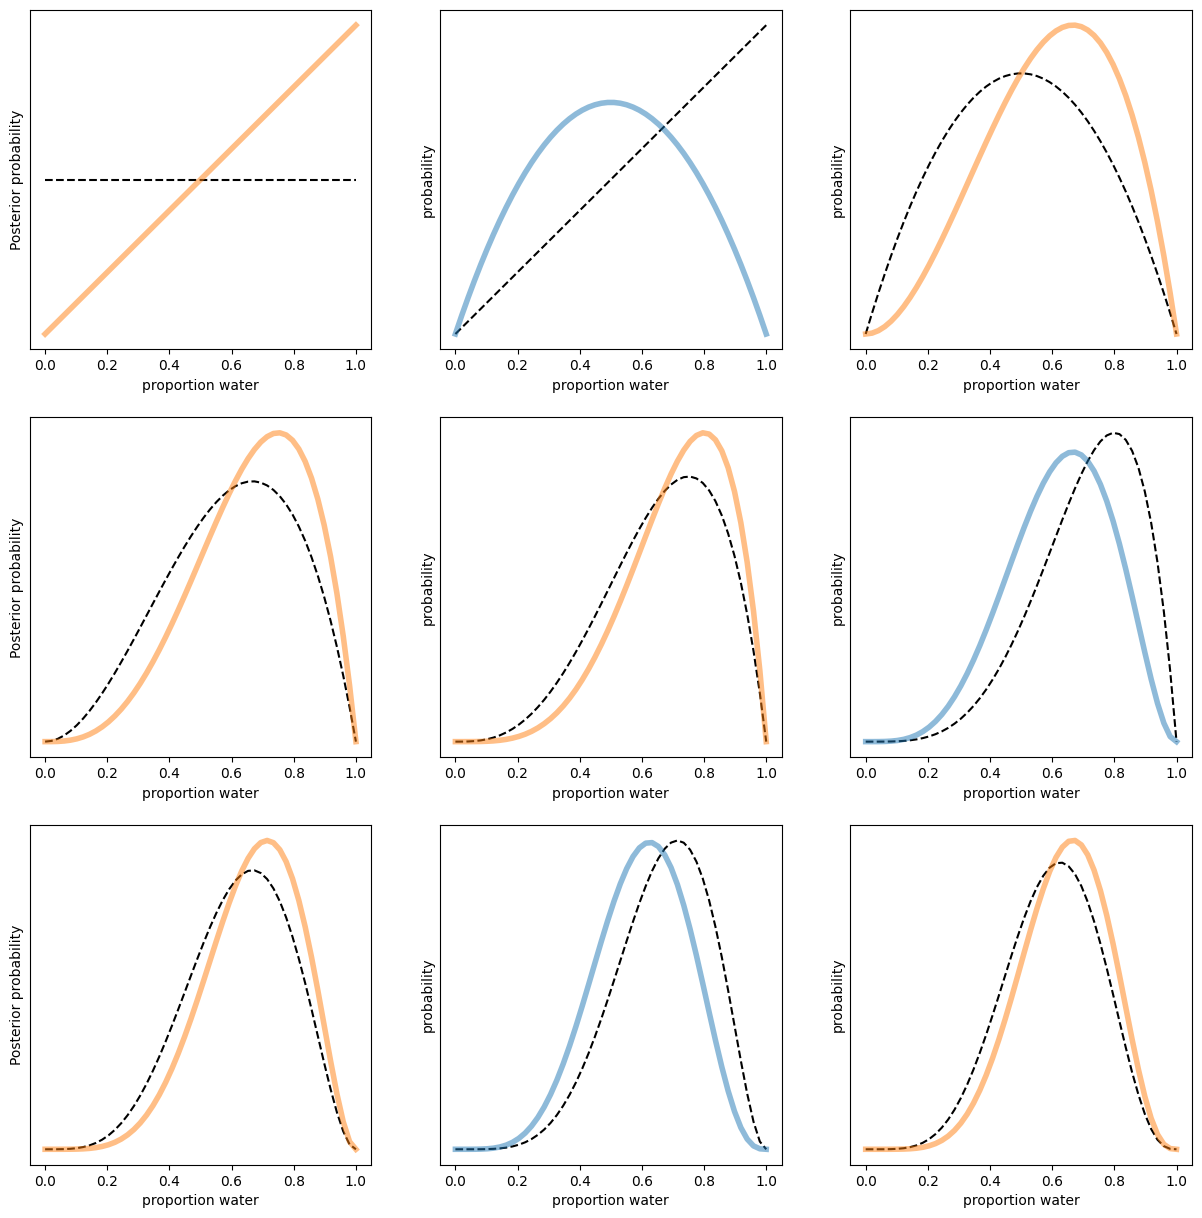

In [290]:
from scipy.special import factorial

def beta(W, L, p):
    return factorial(W + L + 1) / (factorial(W) * factorial(L)) * p ** W * (1 - p) ** L

def plot_beta_from_observation(observations: str, resolution: int = 50, **plot_kwargs):
    """Calculate the posterior for a string of observations"""
    n_W = np.sum(np.array(list(observations)) == "W")
    n_L = np.sum(np.array(list(observations)) == "L")
    proportions = np.linspace(0, 1, resolution)
    
    probs = beta(n_W, n_L, proportions)
    plt.plot(proportions, probs, **plot_kwargs)
    plt.xlabel("proportion water")
    plt.ylabel("probability")
    plt.yticks([])
    
# Tossing the globe
observations = "WLWWWLWLW"

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for idx in range(9):
    ax = axs[idx // 3, idx % 3]
    plt.sca(ax)
    # Plot previous observations
    if idx > 0:
        plot_beta_from_observation(observations[:idx], color='k', ls='--', label='Previous Observations')
    else:
        # First observation
        plot_beta_from_observation("", color='k', ls='--', label='Previous Observations')
        
    color = 'C1' if observations[idx] == "W" else 'C0'
    plot_beta_from_observation(observations[:idx+1], color=color, lw=4, alpha=.5, label='New Observation')
    
    if not idx % 3:
        plt.ylabel("Posterior probability")
    

## From posterior to prediction

* To make predictions, we must average over the entire posterior
* Or Sample from posterior and average those

#### Sampling from Posterior Distribution

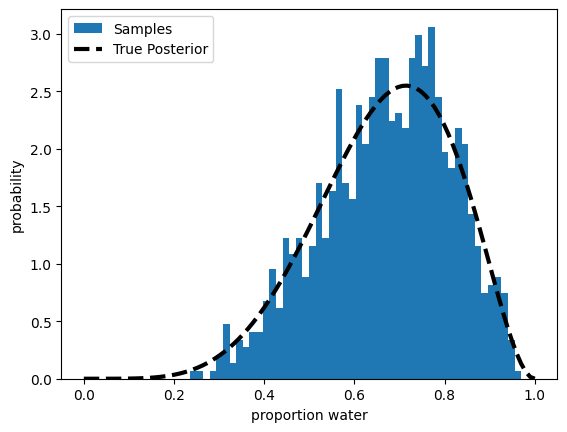

In [293]:
a, b = 6, 3

beta_posterior = stats.beta(a, b)
beta_posterior_samples = beta_posterior.rvs(1000)
plt.hist(beta_posterior_samples, bins=50, density=True, label='Samples')
probs = np.linspace(0, 1, 100)
plt.plot(probs, beta(a-1, b-1, probs), lw=3, label='True Posterior', color='k', ls='--')
plt.xlabel("proportion water")
plt.ylabel("probability")
plt.legend();

#### Sampling from Posterior Predictive Distribution

Posterior Prediction: a prediction for out-of-sample data based on the current posterior estimate

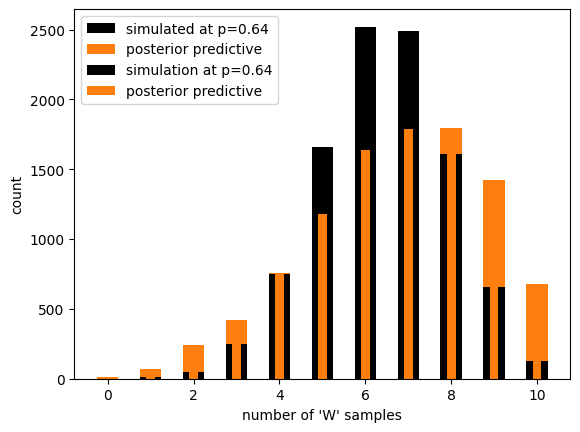

In [299]:
posterior_samples = beta_posterior.rvs(10000)

# Here we use samples from posterior to simulate observations
posterior_predictive = [(simulate_globe_toss(p=p, N=10)== 'W').sum() for p in posterior_samples]
ppd_unique, ppd_counts = np.unique(posterior_predictive, return_counts=True)

specific_prob = .64
specific_predictive = [(simulate_globe_toss(p=specific_prob, N=10)== 'W').sum() for _ in range(10000)]
specific_unique, specific_counts = np.unique(specific_predictive, return_counts=True)

plt.bar(specific_unique, specific_counts, width=.5, color='k', label=f"simulated at p={specific_prob:1.2}")
plt.bar(ppd_unique, ppd_counts, width=.5, color='C1', label="posterior predictive")
plt.xlabel("number of water samples")
plt.ylabel("count")
plt.legend();


# Here we use samples for the posterior to simulate sampling 10 observations from our generative model
ppd_unique, ppd_counts = np.unique(posterior_predictive, return_counts=True)

specific_prob = 0.64
specific_predictive = [(simulate_globe_toss(specific_prob, 10) == 'W').sum() for _ in posterior_samples]
specific_unique, specific_counts = np.unique(specific_predictive, return_counts=True)

plt.bar(specific_unique, specific_counts, width=.5, color='k', label=f'simulation at p={specific_prob:1.2}');
plt.bar(ppd_unique, ppd_counts, width=.2, color='C1', label='posterior predictive');
plt.xlabel("number of 'W' samples")
plt.ylabel('count')
plt.legend();

## Misclassification

Accounting for sampling error

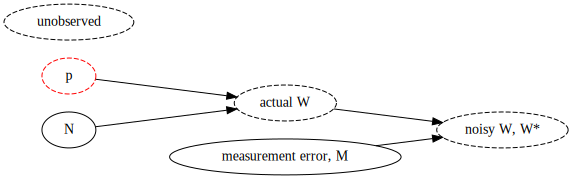

In [300]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("W", "W*"),
        ("M", "W*"),
        ("N", "W")
    ],
    node_props={
        "p": {"color": "red", "style": "dashed"},
        "W": {"style": "dashed", "label": "actual W"},
        "W*": {"style": "dashed", "label": "noisy W, W*"},
        "unobserved": {"style": "dashed"},
        "M": {"label": "measurement error, M"}
    },
    graph_direction="LR"
)

#### Simulation

In [301]:
def simulate_noisy_globe_toss(p=0.7, N=9, error_rate=0.1):
    # True sample
    sample = np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)
    
    # Error-induced sample
    error_trials = np.random.rand(N) < error_rate
    errors_effect_sample_trials = (sample == 'W') & error_trials
    sample[errors_effect_sample_trials] = 'L'
    return sample
    
simulate_noisy_globe_toss()

array(['W', 'W', 'W', 'W', 'L', 'L', 'W', 'W', 'W'], dtype='<U1')

#### Estimator

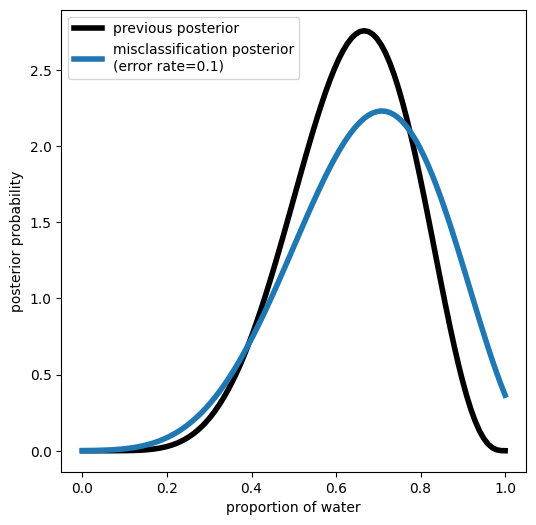

In [302]:
def calculate_unnormalized_n_ways_possible_with_error(p, n_W, n_L, error_rate=0.1):
    n_W_error = (p * (1 - error_rate) + ((1 - p) * error_rate)) ** n_W 
    n_L_error = ((1 - p) * (1 - error_rate) + (p * error_rate)) ** n_L
    return n_W_error * n_L_error

a, b = 6, 3
resolution = 100
proportions = np.linspace(0, 1, resolution)
error_rate = 0.1
error_posterior = np.array(
    [
        calculate_unnormalized_n_ways_possible_with_error(p, a, b, error_rate) for p in proportions
    ]
)
beta_posterior = beta(a, b, proportions)

# Infer normalization constant Z from distribution
error_posterior *= resolution / error_posterior.sum()
beta_posterior *= resolution / beta_posterior.sum()

plt.subplots(figsize=(6, 6))
plt.plot(proportions, beta_posterior, label='previous posterior', color='k', linewidth=4)
plt.plot(proportions, error_posterior, label=f'misclassification posterior\n(error rate={error_rate:1.2})', linewidth=4)
plt.xlabel("proportion of water")
plt.ylabel("posterior probability")
plt.legend();